Refactored from: https://github.com/alxxtexxr/Parkinsons_VGRF_Spatiotemporal_Diagnosis/blob/master/eval_RNNInceptionTimeMoe_kfold10.ipynb

# Libraries

In [1]:
import os
import subprocess

def sparse_clone_repo(repo_url, sparse_dirs, root_dir='.'):
    """
    Clones or updates a Git repository with sparse checkout for specified directories.
    Parameters:
    - repo_url (str): The URL of the Git repository.
    - sparse_dirs (list of str): List of directories to retrieve using sparse checkout.
    - root_dir (str): The root directory where the repository will be stored (default is '/content').
    """
    repo_name = repo_url.rstrip('.git').split('/')[-1] # Extract repo name from URL
    repo_dir = os.path.join(root_dir, repo_name)

    if os.path.isdir(repo_dir):
        print(f"Repo '{repo_name}' already exists. Updating to the latest version...")
        os.chdir(repo_dir)
        subprocess.run(['git', 'reset', '--hard', 'origin/master'], check=True) # Reset to match remote
        subprocess.run(['git', 'pull'], check=True) # Pull latest changes
    else:
        print(f"Repo '{repo_name}' not found. Cloning a fresh copy...")
        os.chdir(root_dir)
        subprocess.run(['git', 'clone', '--no-checkout', repo_url], check=True)
        os.chdir(repo_dir)
        print(f"Initializing sparse checkout for directories: {', '.join(sparse_dirs)}...")
        subprocess.run(['git', 'sparse-checkout', 'init', '--cone'], check=True)
        subprocess.run(['git', 'sparse-checkout', 'set', *sparse_dirs], check=True)
        subprocess.run(['git', 'checkout'], check=True)
    
    print("Now working at repo directory:", os.getcwd())

if os.path.isdir('/content'):
    sparse_clone_repo(
        repo_url='https://github.com/alxxtexxr/Parkinsons_VGRF_Spatiotemporal_Diagnosis_v2.git',
        sparse_dirs=['src', 'data', 'checkpoints'],
        root_dir='/content'
    )

In [2]:
%%capture
%pip install tsai # Required library for the models

In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from pprint import pprint

from src.utils import (
    # Old utils
    print_h, eval_window, eval_person_majority_voting,

    # New utils
    set_seed, init_metrics, update_metrics, save_metrics_to_json,
    # plot_k_fold_roc_curves_multiclass, save_k_fold_roc_curves_multiclass,
    plot_k_fold_roc_curves_multiclass_v2, save_k_fold_roc_curves_multiclass_v2, plot_k_fold_cm,
)
from src.models import RNNInceptionTime, HardMoE

# Config

In [4]:
# Project config
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps') # For Apple Silicon
else:
    device = torch.device('cpu')
print("Device:", device)
seed = 69
set_seed(seed)

# Model config
k_fold_dir_map = {
    # On local machine
    'Ga': 'data/preprocessed/Ga_k10_w500_s500_f16',
    'Ju': 'data/preprocessed/Ju_k10_w500_s500_f16',
    'Si': 'data/preprocessed/Si_k10_w500_s250_f16',

    # On remote server
    # 'Ga': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/datasets/preprocessed_mixed_loocv_v20240731_val_2/kfold10_window500_stride500_feature16_Ga2',
    # 'Ju': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/datasets/preprocessed_mixed_loocv_v20240731_val_2/kfold10_window500_stride500_feature16_Ju3',
    # 'Si': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/datasets/preprocessed_mixed_loocv_v20240731_val_2/kfold10_window500_stride250_feature16_Si8',
}
expert_model_dir_map = {
    # On local machine
    'Ga': 'checkpoints/RNNInceptionTime_Ga_k10_nol',
    'Ju': 'checkpoints/RNNInceptionTime_Ju_k10_nol',
    'Si': 'checkpoints/RNNInceptionTime_Si_k10_ol'

    # On remote server
    # 'Ga': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/outputs/train/RNNInceptionTime_Ga_baseline_20240911161249',
    # 'Ju': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/outputs/train/RNNInceptionTime_Ju_baseline_20240911143621',
    # 'Si': '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/outputs/train/RNNInceptionTime_Si_baseline_20240911144140'
}
gate_model_dir = 'checkpoints/RNNInceptionTime_Gate_k10_Ga_nol_Ju_nol_Si_ol' # On local machine
# gate_model_dir = '../Parkinsons_VGRF_Spatiotemporal_Diagnosis_v0/outputs/train/RNNInceptionTime_Gate_baseline_20240912075120' # On remote server

# Evaluation config
k_fold = 10
batch_size = 8
n_feat = 16
n_class = 4
window_size = 500
max_vgrf_data_len = 25_000
general_metrics_dir = 'evaluations/_general_metrics/RNNInceptionTimeMoE'

Device: mps
Random seed: 69


# Evaluation

In [5]:
moe_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm', 
                            'fpr_multiclass_list', 'tpr_multiclass_list', 'roc_auc_multiclass_list', 'roc_auc_multiclass_avg'])
gate_metrics = init_metrics(['acc', 'f1', 'precision', 'recall', 'cm'])
expert_metrics = {
    'Ga': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Ju': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
    'Si': init_metrics(['acc', 'f1', 'precision', 'recall', 'cm']),
}

study_label_map = {
    'Ga': 0,
    'Ju': 1,
    'Si': 2,
}

for i_fold in range(k_fold):
    print_h(f"FOLD-{i_fold+1}", 128)
    
    expert_model_map = {
        'Ga': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
        'Ju': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
        'Si': RNNInceptionTime(c_in=n_feat, c_out=n_class, seq_len=window_size, bidirectional=True).to(device),
    }

    X_train_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_train_window_GaJuSi = torch.empty(0).long()
    study_labels_train_window_GaJuSi = torch.empty(0).long()
    
    X_val_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_val_window_GaJuSi = torch.empty(0).long()
    study_labels_val_window_GaJuSi = torch.empty(0).long()

    X_test_window_GaJuSi = torch.empty(0, window_size, n_feat).float()
    y_test_window_GaJuSi = torch.empty(0).long()
    study_labels_test_window_GaJuSi = torch.empty(0).long()

    X_val_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
    y_val_person_GaJuSi = torch.empty(0).long()
    # study_labels_val_person_GaJuSi = torch.empty(0).long()

    X_test_person_GaJuSi = torch.empty(0, max_vgrf_data_len, n_feat).float()
    y_test_person_GaJuSi = torch.empty(0).long()
    # study_labels_test_person_GaJuSi = torch.empty(0).long()

    for study, k_fold_dir in k_fold_dir_map.items():
        print_h(f"EXPERT-{study}", 96)

        fold_i_dir_name = os.listdir(k_fold_dir)[i_fold]
        fold_i_dir = os.path.join(k_fold_dir, fold_i_dir_name)

        X_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_train_window.npy'))).float()
        y_train_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_train_window.npy'))).long()
        study_labels_train_window = torch.tensor([study_label_map[study]] * len(y_train_window)).long()
        X_train_window_GaJuSi = torch.cat((X_train_window_GaJuSi, X_train_window), dim=0)
        y_train_window_GaJuSi = torch.cat((y_train_window_GaJuSi, y_train_window), dim=0)
        study_labels_train_window_GaJuSi = torch.cat((study_labels_train_window_GaJuSi, study_labels_train_window), dim=0)

        X_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_window.npy'))).float()
        y_val_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_window.npy'))).long()
        study_labels_val_window = torch.tensor([study_label_map[study]] * len(y_val_window)).long()
        X_val_window_GaJuSi = torch.cat((X_val_window_GaJuSi, X_val_window), dim=0)
        y_val_window_GaJuSi = torch.cat((y_val_window_GaJuSi, y_val_window), dim=0)
        study_labels_val_window_GaJuSi = torch.cat((study_labels_val_window_GaJuSi, study_labels_val_window), dim=0)

        X_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_window.npy'))).float()
        y_test_window = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_window.npy'))).long()
        study_labels_test_window = torch.tensor([study_label_map[study]] * len(y_test_window)).long()
        X_test_window_GaJuSi = torch.cat((X_test_window_GaJuSi, X_test_window), dim=0)
        y_test_window_GaJuSi = torch.cat((y_test_window_GaJuSi, y_test_window), dim=0)
        study_labels_test_window_GaJuSi = torch.cat((study_labels_test_window_GaJuSi, study_labels_test_window), dim=0)

        X_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_val_person.npy'))).float()
        y_val_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_val_person.npy'))).long()
        X_val_person_GaJuSi = torch.cat((X_val_person_GaJuSi, X_val_person), dim=0)
        y_val_person_GaJuSi = torch.cat((y_val_person_GaJuSi, y_val_person), dim=0)

        X_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'X_test_person.npy'))).float()
        y_test_person = torch.tensor(np.load(os.path.join(fold_i_dir, f'y_test_person.npy'))).long()
        X_test_person_GaJuSi = torch.cat((X_test_person_GaJuSi, X_test_person), dim=0)
        y_test_person_GaJuSi = torch.cat((y_test_person_GaJuSi, y_test_person), dim=0)

        train_window_dataset = TensorDataset(X_train_window, y_train_window)
        val_window_dataset = TensorDataset(X_val_window, y_val_window)
        test_window_dataset = TensorDataset(X_test_window, y_test_window)
        
        val_person_dataset = TensorDataset(X_val_person, y_val_person)
        test_person_dataset = TensorDataset(X_test_person, y_test_person)

        train_dataloader = DataLoader(train_window_dataset, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_window_dataset, batch_size=batch_size, shuffle=False)
        test_dataloader = DataLoader(test_window_dataset, batch_size=batch_size, shuffle=False)
        
        expert_model = expert_model_map[study]

        # Load pretrained expert model
        expert_model_dir = expert_model_dir_map[study]
        expert_model_i_name = os.listdir(expert_model_dir)[i_fold]
        expert_model_i_path = os.path.join(expert_model_dir, expert_model_i_name)
        expert_model.load_state_dict(torch.load(expert_model_i_path, map_location=device))

        print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
        (
            _, 
            acc_person_majority_voting, 
            f1_person_majority_voting, 
            precision_person_majority_voting, 
            recall_person_majority_voting, 
            cm_person_majority_voting, 
            *_
        ) = eval_person_majority_voting(
            expert_model, 
            val_person_dataset, 
            criterion=None, 
            average='weighted',
            window_size=window_size, 
            debug=False
        )
        print("acc:", acc_person_majority_voting)
        print("f1:", f1_person_majority_voting)
        print("precision:", precision_person_majority_voting)
        print("recall:", recall_person_majority_voting)
        print("cm:\n", np.array(cm_person_majority_voting))
        print()

        expert_metrics[study] = update_metrics(expert_metrics[study], {
            'acc': acc_person_majority_voting,
            'f1': f1_person_majority_voting,
            'precision': precision_person_majority_voting,
            'recall': recall_person_majority_voting,
            'cm': cm_person_majority_voting,
        })

    print_h("GATE", 96)

    # train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, y_train_window_GaJuSi)
    # val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, y_val_window_GaJuSi)
    # test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, y_test_window_GaJuSi)

    train_window_dataset_GaJuSi = TensorDataset(X_train_window_GaJuSi, study_labels_train_window_GaJuSi)
    val_window_dataset_GaJuSi = TensorDataset(X_val_window_GaJuSi, study_labels_val_window_GaJuSi)
    test_window_dataset_GaJuSi = TensorDataset(X_test_window_GaJuSi, study_labels_test_window_GaJuSi)

    train_dataloader_GaJuSi = DataLoader(train_window_dataset_GaJuSi, batch_size=batch_size, shuffle=True)
    val_dataloader_GaJuSi = DataLoader(val_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)
    test_dataloader_GaJuSi = DataLoader(test_window_dataset_GaJuSi, batch_size=batch_size, shuffle=False)

    gate_model = RNNInceptionTime(c_in=n_feat, c_out=len(study_label_map.keys()), seq_len=window_size, bidirectional=True).to(device)

    # Load pretrained gate model
    gate_model_i_name = os.listdir(gate_model_dir)[i_fold]
    gate_model_i_path = os.path.join(gate_model_dir, gate_model_i_name)
    gate_model.load_state_dict(torch.load(gate_model_i_path, map_location=device))

    print_h("EVALUATION ON WINDOW DATA", 64)
    
    _, acc_window, f1_window, precision_window, recall_window, cm_window = eval_window(gate_model, test_dataloader_GaJuSi, average='weighted')

    print("acc:", acc_window)
    print("f1:", f1_window)
    print("precision:", precision_window)
    print("recall:", recall_window)
    print("cm:\n", np.array(cm_window))
    print()

    gate_metrics = update_metrics(gate_metrics, {
        'acc': acc_window,
        'f1': f1_window,
        'precision': precision_window,
        'recall': recall_window,
        'cm': cm_window,
    })

    print_h("MoE", 96)

    val_person_dataset_GaJuSi = TensorDataset(X_val_person_GaJuSi, y_val_person_GaJuSi)
    test_person_dataset_GaJuSi = TensorDataset(X_test_person_GaJuSi, y_test_person_GaJuSi)

    moe_model = HardMoE(experts=expert_model_map.values(), gate=gate_model)

    print_h("EVALUATION ON PERSON DATA BY MAJORITY VOTING", 64)
    (
        _, 
        acc_person_majority_voting, 
        f1_person_majority_voting, 
        precision_person_majority_voting, 
        recall_person_majority_voting, 
        cm_person_majority_voting, 
        _, _, _, 
        fpr_multiclass_list_person_majority_voting, 
        tpr_multiclass_list_person_majority_voting, 
        roc_auc_multiclass_list_person_majority_voting, 
        roc_auc_multiclass_avg_person_majority_voting
    ) = eval_person_majority_voting(
        moe_model, 
        val_person_dataset_GaJuSi, 
        criterion=None, 
        average='weighted',
        window_size=window_size, 
        debug=False
    )
    print("acc:", acc_person_majority_voting)
    print("f1:", f1_person_majority_voting)
    print("precision:", precision_person_majority_voting)
    print("recall:", recall_person_majority_voting)
    print("cm:\n", np.array(cm_person_majority_voting))
    print()

    moe_metrics = update_metrics(moe_metrics, {
        'acc': acc_person_majority_voting,
        'f1': f1_person_majority_voting,
        'precision': precision_person_majority_voting,
        'recall': recall_person_majority_voting,
        'cm': cm_person_majority_voting,
        'fpr_multiclass_list': fpr_multiclass_list_person_majority_voting, 
        'tpr_multiclass_list': tpr_multiclass_list_person_majority_voting, 
        'roc_auc_multiclass_list': roc_auc_multiclass_list_person_majority_voting,
        'roc_auc_multiclass_avg': roc_auc_multiclass_avg_person_majority_voting,
    })

    # DEBUG: Test for only one fold
    # break

                                                             FOLD-1                                                             
                                           EXPERT-Ga                                            
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
cm:
 [[5 0 0 0]
 [0 6 0 0]
 [0 0 3 0]
 [0 0 0 2]]

                                           EXPERT-Ju                                            
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 1.0
f1: 1.0
precision: 1.0
recall: 1.0
cm:
 [[3 0 0 0]
 [0 4 0 0]
 [0 0 7 0]
 [0 0 0 1]]

                                           EXPERT-Si                                            
          EVALUATION ON PERSON DATA BY MAJORITY VOTING          
acc: 0.875
f1: 0.875
precision: 0.90625
recall: 0.875
cm:
 [[3 1 0 0]
 [0 3 0 0]
 [0 0 1 0]
 [0 0 0 0]]

                                              GATE                                        

## MoE Metrics

In [6]:
print_h("MoE METRICS", 128)
save_metrics_to_json(moe_metrics, general_metrics_dir, '_MoE.json')
print()
pprint(moe_metrics, sort_dicts=False)

                                                          MoE METRICS                                                           
Saved as: evaluations/_general_metrics/RNNInceptionTimeMoE/_MoE.json

{'acc': {'folds': [0.9230769230769231,
                   0.9743589743589743,
                   0.8717948717948718,
                   0.9743589743589743,
                   0.9487179487179487,
                   0.9487179487179487,
                   1.0,
                   0.9743589743589743,
                   0.8974358974358975,
                   0.9230769230769231],
         'avg': 0.9435897435897436,
         'std': 0.03768445758127965},
 'f1': {'folds': [0.9233290863725645,
                  0.9742763945662497,
                  0.8731536662571145,
                  0.9743589743589743,
                  0.949381536338058,
                  0.9482184482184481,
                  1.0,
                  0.9742612942612943,
                  0.8982060674368366,
                  0.92332

### MoE ROC Curves

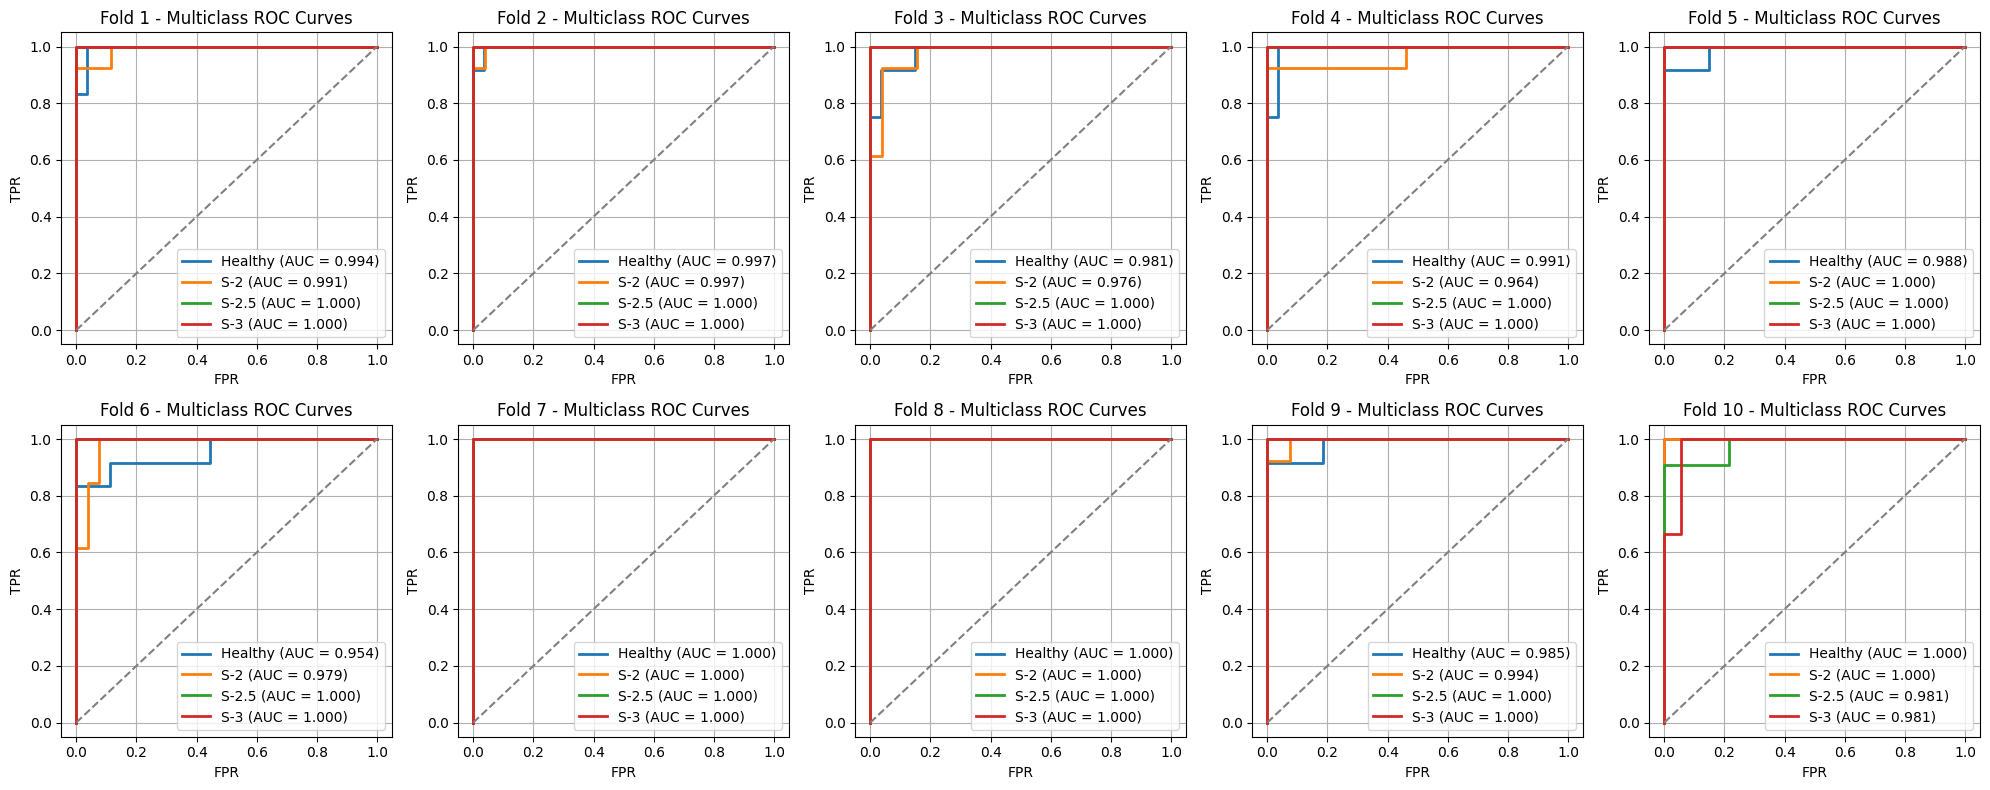

Saved in: evaluations/roc_curves_multiclass/v2


In [7]:
# plot_k_fold_roc_curves_multiclass(
#     fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
#     tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
#     auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
# )

plot_k_fold_roc_curves_multiclass_v2(
    fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
    tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
    auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
    class_names=["Healthy", "S-2", "S-2.5", "S-3"],
)

In [8]:
# save_k_fold_roc_curves_multiclass(
#     fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
#     tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
#     auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
# )

# save_k_fold_roc_curves_multiclass_v2(
#     fpr_folds=moe_metrics['fpr_multiclass_list']['folds'],
#     tpr_folds=moe_metrics['tpr_multiclass_list']['folds'],
#     auc_folds=moe_metrics['roc_auc_multiclass_list']['folds'],
# )

### MoE Confusion Matrices

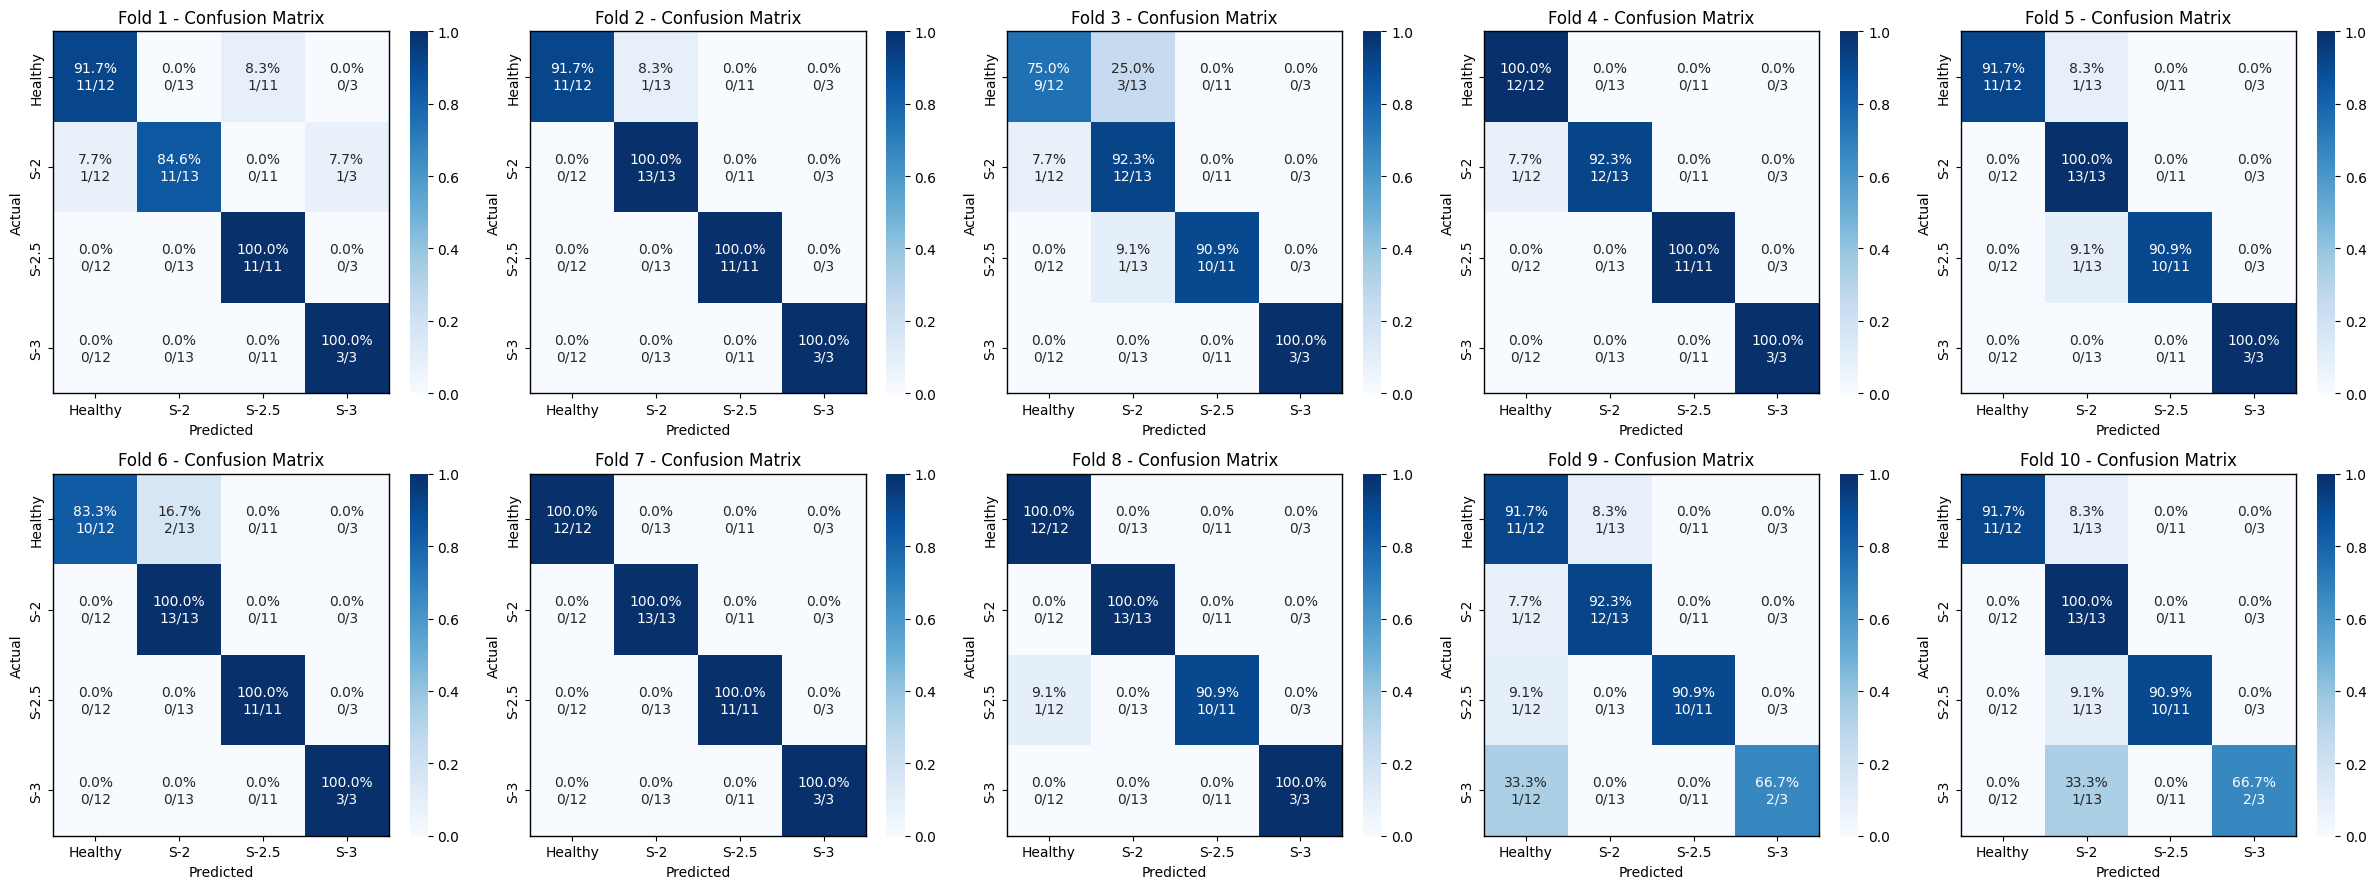

Saved in: evaluations/cm


In [9]:
plot_k_fold_cm(moe_metrics['cm']['folds'], class_names=["Healthy", "S-2", "S-2.5", "S-3"])

## Gate Metrics

In [10]:
print_h("GATE METRICS", 128)
save_metrics_to_json(gate_metrics, general_metrics_dir, 'Gate.json')
print()
pprint(gate_metrics)

                                                          GATE METRICS                                                          
Saved as: evaluations/_general_metrics/RNNInceptionTimeMoE/Gate.json

{'acc': {'avg': 0.972178273079449,
         'folds': [0.9717247879359096,
                   0.9678638941398866,
                   0.9971698113207547,
                   0.9604147031102733,
                   0.99906191369606,
                   0.9623706491063029,
                   0.9679547596606974,
                   0.9717514124293786,
                   0.9678942398489141,
                   0.9555765595463138],
         'std': 0.013829995682816308},
 'cm': {'folds': [[[209, 3, 4], [2, 153, 2], [11, 8, 669]],
                  [[215, 1, 0], [2, 149, 3], [15, 13, 660]],
                  [[215, 1, 0], [0, 155, 1], [0, 1, 687]],
                  [[206, 2, 8], [3, 148, 6], [16, 7, 665]],
                  [[216, 0, 0], [0, 162, 0], [1, 0, 687]],
                  [[202, 12, 2], [1, 15

## Expert-Ga Metrics

In [11]:
print_h("EXPERT-Ga METRICS", 128)
save_metrics_to_json(expert_metrics['Ga'], general_metrics_dir, 'Ga.json')
print()
pprint(expert_metrics['Ga'])

                                                       EXPERT-Ga METRICS                                                        
Saved as: evaluations/_general_metrics/RNNInceptionTimeMoE/Ga.json

{'acc': {'avg': 0.9375,
         'folds': [1.0,
                   1.0,
                   0.9375,
                   0.9375,
                   1.0,
                   0.9375,
                   1.0,
                   0.9375,
                   0.8125,
                   0.8125],
         'std': 0.06846531968814576},
 'cm': {'folds': [[[5, 0, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[5, 0, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[5, 0, 0, 0], [1, 5, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[5, 0, 0, 0], [1, 5, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[5, 0, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[4, 1, 0, 0], [0, 6, 0, 0], [0, 0, 3, 0], [0, 0, 0, 2]],
                  [[5, 0, 

## Expert-Ju Metrics

In [12]:
print_h("EXPERT-Ju METRICS", 128)
save_metrics_to_json(expert_metrics['Ju'], general_metrics_dir, 'Ju.json')
print()
pprint(expert_metrics['Ju'])

                                                       EXPERT-Ju METRICS                                                        
Saved as: evaluations/_general_metrics/RNNInceptionTimeMoE/Ju.json

{'acc': {'avg': 0.9866666666666667,
         'folds': [1.0,
                   1.0,
                   0.9333333333333333,
                   1.0,
                   1.0,
                   1.0,
                   1.0,
                   1.0,
                   0.9333333333333333,
                   1.0],
         'std': 0.026666666666666658},
 'cm': {'folds': [[[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
                  [[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
                  [[2, 1, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
                  [[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
                  [[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
                  [[3, 0, 0, 0], [0, 4, 0, 0], [0, 0, 7, 0], [0, 0, 0, 1]],
 

## Expert-Si Metrics

In [13]:
print_h("EXPERT-Si METRICS", 128)
save_metrics_to_json(expert_metrics['Si'], general_metrics_dir, 'Si.json')
print()
pprint(expert_metrics['Si'])

                                                       EXPERT-Si METRICS                                                        
Saved as: evaluations/_general_metrics/RNNInceptionTimeMoE/Si.json

{'acc': {'avg': 0.975,
         'folds': [0.875, 1.0, 1.0, 1.0, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0],
         'std': 0.049999999999999996},
 'cm': {'folds': [[[3, 1, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 2, 1, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0], [0, 0, 0, 0]],
                  [[4, 0, 0, 0], [0, 3, 0, 0], [0, 0, 1, 0]